# Data re-uploading for a single-qubit universal classifier - Vol. III

## A new model for Quantum Machine Learning with one or few qubits


### Abstract
Welcome again, qiskitters. This is the third and last part of the tutorial *Data re-uploading for a single-qubit universal classifier*. We have learnt a little bit about Quantum Machine Learning and how to use the IBMQ Quantum Computers for solving problems related to Supervised Machine Learning. We have already used one qubit for classifying binary and non-binary data. In this third volume we will extend the idea previously explained for classifying non-binary data with two qubits. This tutorial is based on the work in [1].


### Introduction
In the second part of the tutorial we classified points from four quadrants using one qubit and classical optimizers. A picture of obtained results can be seen in Fig. 1. However, we can take one further step, which is classifying a non-binary data set with more than one qubit. We will tackle the same problem as before, but this time we will take two qubits. 
<img src="squares_example.png" width="300"> <img src="squares_example_2.png" width="300"> 
*Fig. 1: Results obtained in the first part of the tutorial for classifying four quadrants with only one qubit and a classical optimizer. This result was obtained with a noisy simulation.*
<br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import itertools
from scipy.optimize import minimize

from functions_aux import *

from qiskit import QuantumCircuit, Aer, execute, IBMQ, transpile
from qiskit.providers.aer import QasmSimulator, noise

IBMQ.load_account()

simulator='qasm_simulator'
quantum_device='ibmqx2'

#### The double-qubit solution: there are four orthogonal states

The strategy followed now to solve this problem is using more qubits. For a 4 classes problem, a 2-qubit Hilbert space should be enough as there are as many orthogonal states as labels. The label states become then

$$
| \psi_0 \rangle = | 00 \rangle \qquad
| \psi_1 \rangle = | 01 \rangle \qquad
| \psi_2 \rangle = | 10 \rangle \qquad
| \psi_3 \rangle = | 11 \rangle \qquad
$$
Notice that every $y$ is related to its corresponding vector in the basis of the Hilbert space of a 2-qubit system. Shortly, we may say that $|y\rangle = |y_1 y_0\rangle$, where $(y_1 y_0)$ is the binary representation of $y = \lbrace0,1,2,3\rbrace$.
The circuit is then 
<img src="4classes_2qubit.png" width="500"> 
*Fig. 2: Circuit for the classification of four quadrants with 2 qubits. The $X$ gates will appear depending on the class of the point, $(y_1 y_0)$ is the binary representation of $y = \lbrace0,1,2,3\rbrace.$*
<br>

As now there are more qubits in the $U$ gate, we need to define the Ansatz we are about to use. This choice is heuristic, and there could be other Änsatze with better results. This Ansatz is applied because it is as general as possible.

<img src="circuit_2q.png" width="300"> 
*Fig. 3: Circuit for the Ansatz for the classification of four quadrants with 2 qubits. The $L(i)$ gates are defined in the same way as in the first part of the tutorial.*
<br>

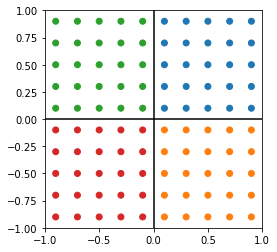

In [2]:
grid = 10
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X_train = np.asfarray(X)
Y_train = squares_labels(X_train)

fig = draw_squares((X_train, Y_train))

In [3]:
def measurement_squares_2q(x, y, parameters, device, err_like_dev, noise_objects):
    """
    Create the basic circuit for this problem
    Input:
        x: the x input of the data
        y: the label of the data
        parameters: variables of the classifier
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
        noise_objects: noise model, coupling map and basis gates for the error model
                
    Output:
        The fidelity between the state given by (x, y) and its corresponding label state
        
    Notice that the circuit is designed in a way that fits the architecture of 'ibmqx2'
    The central qubit (2) is the one we will measure
    The easiest way to construct the circuit in this cell is to take Fig. 2 and interchange the central and down qubits
    """
    if len(parameters) % 10 != 0:
        raise ValueError('The number of parameters is not correct')
        # Error message in case the number of parameters does not fit the problem; notice that, as we have 2 qubits now, there are more parameters
        
    qubits=2
    layers = len(parameters) // 5 // qubits
    parameters = parameters.reshape(qubits, layers, 5) # It is easier to manage variables this way
    
    C = QuantumCircuit(5,1) # We create the Quantum circuit, we need 5 qubits and one classical register
        
    if y == 1:
        C.x(4)
    
    elif y == 2:
        C.x(3)
    
    elif y == 3:
        C.x(4)
        C.x(3) # This gates will appear depending on the class of the point

    C.h(2) # This is part of the SWAP test
    for l in range(layers - 1):
        for q in range(qubits):
            C.u3(parameters[q,l,0] * x[0] + parameters[q,l, 1],
                 parameters[q,l, 2] * x[1] + parameters[q,l, 3],
                 parameters[q,l, 2], q)
        C.cx(0,1)
         # This loop creates all unitary gates for classifying data, there are two local gates per layer and one entangling gate
    for q in range(qubits):
        C.u3(parameters[q,-1,0] * x[0] + parameters[q,-1, 1],
                 parameters[q,-1, 2] * x[1] + parameters[q,-1, 3],
                 parameters[q,-1, 2], q)
        # The last layer has got no entangling gate

    C.cswap(2, 0, 4)
    C.cswap(2, 1, 3) 
    C.h(2) 
    C.measure([2], [0])  # This is part of the SWAP test, will give us the fidelity
    
    try:
        backend = Aer.get_backend(device)# Try to select the QasmSimulator from the Aer provider
        
    except: # If the device given is not the qasm simulator
        provider = IBMQ.get_provider(hub='ibm-q') 
        backend=provider.get_backend(device)  # This selects the real devices, one must be logged into IBMQ for using the function
        C=transpile(C, backend=backend, optimization_level=1) # Transpiling of the circuit, this adjusts the circuit to be convenient for the chosen provider, the optimization level can be adjusted for better results


    sh = 1024 # Number of shots for the execution, this can be easily changed
    if err_like_dev!= None: # If we want a noise model, other functions are designed to make this work even with no input variables in the function
        noise_model, coupling_map, basis_gates = noise_objects # Unpack the noise objects, this way we do not have to compute them every time
        result = execute(C, backend, shots=sh, noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result() # Execution
    else: # If we consider the device as fault tolerant
        result = execute(C, backend, shots=sh, optimization_level = 1).result() # Execution
    counts = result.get_counts(C) # Get the number of counts for each state
    fidelity = 2 * counts['0'] / sh - 1 # Compute the fidelity 
    return fidelity


def check_squares_2q(X, parameters, device, err_like_dev=None):
    """
    Compute the guessed label of a X dataset, this function needs no labels
    Input:
        X: the x input of the dataset
        parameters: variables of the classifier, which at this point should be optimized for good results
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
                
    Output:
        The fidelity between the state given by (x, y) and its corresponding label state
    """
    noise_objects=None # This section creates the noise model in case we want it
    if err_like_dev!= None:
        print('Checking with noise model')
        provider = IBMQ.get_provider(hub='ibm-q')
        err_device = provider.get_backend(err_like_dev)
        properties = err_device.properties()
        coupling_map = err_device.configuration().coupling_map
        noise_model = noise.device.basic_device_noise_model(properties)
        basis_gates = noise_model.basis_gates
        noise_objects = noise_model, coupling_map, basis_gates
        
    Fidelities = np.empty((len(X), 4)) # Empty vector for all fidelities
    for i,x in enumerate(X):
        for y in range(4):
             Fidelities[i, y]= measurement_squares_2q(x, y, parameters, device, err_like_dev, noise_objects) # Checks if it is inside the circle 

    return Fidelities
    
    
def cost_function_squares_2q(parameters, Data, device, err_like_dev, noise_objects):
    """
    Compute the cost function for a dataset
    Input:
        Data = (X, Y): the x and y input of the dataset
        parameters: variables of the classifier, which at this point should be optimized for good results
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
        noise_objects: noise model, coupling map and basis gates for the error model
                
    Output:
        The cost function for a training Dataset
    """
    noise_model, coupling_map, basis_gates = noise_objects
    X = Data[0]
    Y = Data[1]
    chi2 = 0
    for x, y in zip(X, Y):
        chi2 += (1 - measurement_squares_2q(x, y, parameters, device, err_like_dev, noise_objects))**2 # Compute the cost function for every point and sum them all
        
    return chi2 / len(Y)

def get_optimal_parameters(parameters, Data, device, err_like_dev=None):
    """
    Get the optimal parameters of a Dataset
    Input:
        Data = (X, Y): the x and y input of the dataset
        parameters: variables of the classifier, which at this point should be optimized for good results
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
                
    Output:
        Optimal parameters
    """
    noise_objects=(None, None, None) # This section creates the noise model in case we want it
    if err_like_dev!= None:
        print('Optimization with noise model')
        provider = IBMQ.get_provider(hub='ibm-q')
        err_device = provider.get_backend(err_like_dev)
        properties = err_device.properties()
        coupling_map = err_device.configuration().coupling_map
        noise_model = noise.device.basic_device_noise_model(properties)
        basis_gates = noise_model.basis_gates
        noise_objects = noise_model, coupling_map, basis_gates
        
    result_min = minimize(cost_function_squares_2q, parameters, args=((X_train, Y_train), simulator, err_like_dev, noise_objects), method='Powell')
    
    return result_min


From this moment we will repeat exactly the same as in the one-qubit case. There are no different steps taken. Thus, in order to make this tutorial more readable, there is no need for detailed explanations.

In [4]:
#layers=
#parameters = np.zeros(5*2*layers)
#solution = get_optimal_parameters(parameters,(X_train, Y_train), simulator, None)

In [5]:
# Optimized parameters for different numbers of layers
# Commented we can see the value of the cost function after minimization
# These values were obtained with the qasm simulator with no noise model

sol2=np.array([ 4.45129067e+00, -1.56875684e+00,  2.01933558e+00,  1.77740136e-01,
        8.78500962e-01,  1.79047190e+00, -1.76865802e-01,  1.57838726e+00,
        6.54460664e+00,  6.83160045e+00,  2.39327399e+00,  8.27917274e-03,
        1.47120756e-01,  3.70576157e-01, -1.02111974e+01, -2.68658232e-01,
       -1.15105832e+00, -2.31561508e-02,  9.81351719e+00, -1.34449687e+01]) #0.2850864028930664

sol3=np.array([ 0.06607868, -1.47318115,  0.99179411,  0.0186335 , -1.54075934,
       -3.01268191,  1.32373749,  0.0093197 , -1.4604332 ,  3.10745051,
       -2.55232083, -0.25882256,  1.33968079, -2.80508489,  1.07697963,
        0.54669349,  0.75734084, -2.21788686,  1.57259574, -0.57289583,
        0.35731731,  0.44065143,  1.27718811,  0.22387249,  5.74286817,
        0.93791628,  0.12577838, -0.02754623, -0.42773836,  4.87704546]) #0.13968181610107422

sol4=np.array([ 3.1898398 , -0.37025668, -1.73674639,  0.84073677,  1.15224075,
       -1.36204783,  1.07326992,  1.5908699 , -0.35888521,  4.52392772,
        0.45898233,  1.43217251,  1.63209173,  0.11613165,  4.04809762,
        2.04014856,  0.37932187,  0.89549906,  2.08417428, -0.53604735,
       -0.57343669, -0.22951699,  0.60406831, -2.51368728,  6.62893304,
        0.13499539,  1.45433562, -0.37528303, -0.21841795, -5.37530558,
       -0.04217691, -0.13016771,  0.65035978,  0.0128586 ,  3.03076242,
        0.55152724, -0.4460519 ,  0.02672925,  0.43853393,  0.94828499]) #0.12033618927001953

sol5=np.array([ 8.28873173e-01,  5.88256808e-01,  2.22790220e+00, -2.13979916e-01,
       -4.16913127e-01, -1.94147125e+00,  9.26795999e-01,  6.09683748e-01,
        1.40645880e-01,  1.56835179e+01,  1.67211776e+00,  4.30853872e-01,
        4.02343415e-01, -1.53428227e-01,  4.35068647e+00,  8.07221883e-01,
        2.47212258e-01,  9.35398337e-01, -5.05220821e-01,  3.94402119e+00,
       -4.07666813e-01,  1.36728158e+00,  9.98978477e-01, -5.44535629e+01,
        1.17085417e+01, -6.06856233e-01,  2.73826664e-01, -3.53898263e-01,
        1.11934070e+00, -3.41848180e-01,  1.25177133e-02,  4.76414413e-01,
       -3.75213923e-01, -4.36393734e-01,  5.44883302e+01, -1.23180096e+00,
        1.10944978e+00,  7.28155127e-01,  3.98446907e-01,  6.03413819e+00,
        4.90540125e-02,  2.69410376e-01, -3.18790950e-01,  6.67271477e-01,
        2.41327405e+00,  3.46193861e-01, -7.06961704e-01,  4.32356569e-01,
        1.00982334e+00,  3.33594588e+00]) #0.10045291900634766

optimal_parameters=sol5



The classifier guesses the right label a 97 % of times


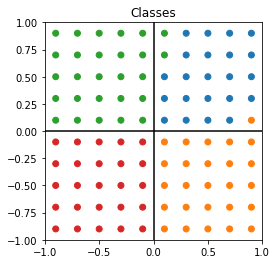

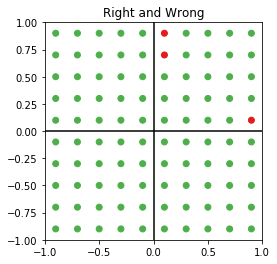

In [6]:
# Check performance in the training set

F_train = check_squares_2q(X_train, optimal_parameters, simulator)

fig=draw_squares((X_train, np.argmax(F_train, axis=1)), title = 'Classes')

checks_train = (Y_train==np.argmax(F_train, axis=1)).astype(int)
fig=draw_squares((X_train, checks_train), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100* sum(checks_train) // len(checks_train)))

The classifier guesses the right label a 99 % of times


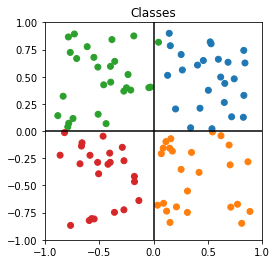

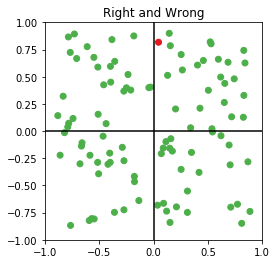

In [7]:
# Check performance in an unseen dataset with weighted fidelities

test=100
X_test = 1.8*np.random.rand(test, 2) - .9
Y_test = squares_labels(X_test)

F_test = check_squares_2q(X_test, optimal_parameters, simulator)

opt_weights = get_optimal_weights(Y_test, F_test)

F_wtest = weighted_fidelity(F_test, opt_weights)
fig=draw_squares((X_test, F_wtest), title = 'Classes')

checks_wtest = (Y_test==F_wtest).astype(int)
fig=draw_squares((X_test, checks_wtest), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100 * sum(checks_wtest) // len(checks_wtest)))

Checking with noise model
The classifier guesses the right label a 97 % of times


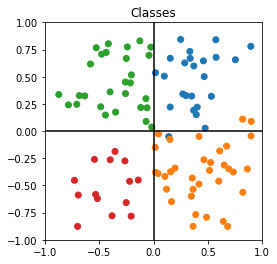

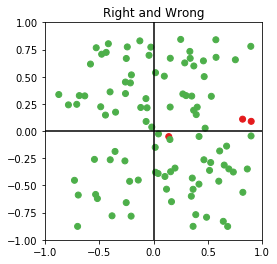

In [8]:
# Trial in an actual quantum device

qtest=100
X_qtest = 1.8*np.random.rand(qtest, 2) - .9
Y_qtest = squares_labels(X_qtest)

F_qtest = check_squares_2q(X_qtest, optimal_parameters, simulator, err_like_dev=quantum_device)  # For a noisy simulation
#F_qtest = check_squares_2q(X_qtest, optimal_parameters, quantum_device) # For an actual quantum device

opt_weights = get_optimal_weights(Y_qtest, F_qtest) #Optimize weights

F_wqtest = weighted_fidelity(F_qtest, opt_weights)
fig=draw_squares((X_qtest, F_wqtest), title = 'Classes')

checks_wqtest = (Y_qtest==F_wqtest).astype(int)
fig=draw_squares((X_qtest, checks_wqtest), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100* sum(checks_wqtest) // len(checks_wqtest)))

## Conclusions

We have shown that it is possible to extend the single-qubit method to a quantum system with two qubits and, thus, a larger Hilbert space. This can be further generalized to any size of the quantum system. We have got one clear advantage: the dimensionality of the Hilbert space grows exponentially. Thus, we can get a large number of orthogonal states, which can be used as the label states of the classifyer, with few qubits. The addition of more qubits and entanglement may allow for a quantum advantage.

## Summary of results

Below there are tables summarizing some results obtained with this program for different problems, circuits and number of layers. First table contains the $\chi^2$ functions, second table contains the accuracy for the training set, as measured following the rule of maximum, and third table contains the accuracy for the test set after weighting fidelities. Results could vary because quantum measurements are probabilistic and the test points are not fixed. It is quite contradictory, but a smaller $\chi^2$ may not lead to a better classification. It depends on the number of qubits and choice of the label states. In general, for non-orthogonal label states, the values of $\chi^2$ are smaller, but as all label states are close to each other, wrong measurements could happen. In this tables, every column *Circle, Quadrants, Quadrants - 2 qubits*

|  layers |  Circle | Quadrants | Quadrants - 2 qubits |
|---|---|---|---|
| 2 | 0.11 | 0.05 | 0.29 | 
| 3 | 0.11 | 0.03 | 0.14 | 
| 4 | 0.08 | 0.06 | 0.12 | 
| 5 | 0.11 | 0.05 | 0.10 | 


*Tab. 1: Value of $\chi^2$ for different problems and layers, tested with `qasm simulator`. Values over 100 points.*

|  layers |  Circle | Quadrants | Quadrants - 2 qubits |
|---|---|---|---|
| 2 | 87 | 77 | 70 | 
| 3 | 89 | 90 | 97 | 
| 4 | 89 | 69 | 96 | 
| 5 | 90 | 85 | 98 | 


*Tab. 2: Accuracy in the training set after weighting fidelities for different problems and layers, tested with `qasm simulator`. We applied the rule of maximum. Values over 100 points*

|  layers |  Circle | Quadrants | Quadrants - 2 qubits |
|---|---|---|---|
| 2 | 96(94) | 83(90) | 72(72) | 
| 3 | 90(91) | 90(86) | 97(98) | 
| 4 | 93(93) | 84(80) | 95(96) | 
| 5 | 93(90) | 83(89) | 95(97) | 


*Tab. 3: Accuracy in the test set for different problems and layers, optimized with `qasm simulator` taking in account `ibmqx2`'s errors. Numbers between parenthesis are noise-free. Values over 100 points.*

## General conclusions
We have shown that there is a manner of classifying classical data making use of few qubits, while the features of the data have got no restrictions. The key step we have taken is *re-uploading* data. By reuploading data we can re-introduce the information in within the data several times in the circuit. This allows the algorithm to work on NISQ computers and, perhaps, to be a feasible algorithm for Quantum Machine Learning in the near future.

Nevertheless, we must not to forget that as this algorithm requires few quantum resources, that is few qubits and gates, it may be an useful piece of larger quantum procedures. 

However, it is important to remark that we have applied no feature maps, no specific preprocessing depending on our datasets. The only processing we have classically introduced is the construction of the quantities $a x + b$ as the arguments of the unitary operations. Nevertheless, this processing is linear, thus the classifier receives no information from the arguments of the unitary operations.

The results are pretty satisfactory. We have classified our datasets with an accuracy near or even over 90% for all three cases. It is true that these datasets are not the largest of datasets or the most complicated ones, but the current capabilities of quantum computers make unfeasible the tackling of much more complex problems with this method.


#### References


[1] Pérez-Salinas, A., Cervera-Lierta, A., Gil-Fuster, E., & Latorre, J. I. (2019). *Data re-uploading for a universal quantum classifier.* arXiv preprint [arXiv:1907.02085](https://arxiv.org/abs/1907.02085)<br>


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table